<a href="https://colab.research.google.com/github/canans/NLP-ML-DL/blob/main/knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.  [**What is Knowledge Graph?**](#KG1)
2.  How Does It Work?
3. Examples Knowledge Graph with Spacy
   1. Tokenization
   2. Parts of Speech (POS) Tagging
   3. Relation / Predicate Extraction







![](https://www.csee.umbc.edu/courses/graduate/691/fall19/07/images/kg_header.png)

## 1.What is Knowledge Graph?<a id="KG1"></a> <br>

A Knowledge Graph is a model of a knowledge domain created by subject-matter experts with the help of intelligent machine learning algorithms. It provides a structure and common interface for all of your data and enables the creation of smart multilateral relations throughout your databases. Structured as an additional virtual data layer, the Knowledge Graph lies on top of your existing databases or data sets to link all your data together at scale – be it structured or unstructured.

![](https://miro.medium.com/max/1050/1*x4SmgMrwe7BLmFk0sbwgew.png)

Elementary unit of a knowledge graph is a triplet subject-predicate-object, often denoted as (head, relation, tail) or (h, r, t)


Ordinary query to a knowledge base looks like this: find entity by name “Arthur Cayley”, find tail of his “Hometown” relation and return it’s “Name” property. As a result you should probably get “London”.


## 3.Example of Knowledge Graph with Spacy <a id="KG3"></a> <br>


To build a knowledge graph from the text, it is important to make our machine understand natural language. This can be done by using **NLP** techniques such as **sentence segmentation**, **dependency parsing**, **parts of speech tagging**, **and entity recognition**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

Importing Wikipedia Sentences

In [3]:
text=pd.read_csv("./wiki_sentences_v2.csv")
text.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


### a.Tokenization <a id="KG31"></a> <br>
**Tokenization** and sentence **segmentation** in Stanza are jointly performed by the *TokenizeProcessor*. This processor splits the raw input text into tokens and sentences, so that downstream annotation can happen at the sentence level. This processor can be invoked by the name *tokenize*.
 
![](https://miro.medium.com/max/1107/1*N1YsdSJihlzJrvYBUDI-_A.jpeg) 

In [4]:
doc = nlp("confused and frustrated, connie decides to leave on her own")

for tok in doc:
  print(tok.text, "--------->", tok.dep_)

confused ---------> advcl
and ---------> cc
frustrated ---------> conj
, ---------> punct
connie ---------> nsubj
decides ---------> ROOT
to ---------> aux
leave ---------> xcomp
on ---------> prep
her ---------> poss
own ---------> pobj


### b.Parts of Speech (POS) Tagging <a id="KG32"></a> <br>
Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence, which means that, unlike phrase matching, which is performed at the sentence or multi-word level, parts of speech tagging is performed at the token level.WithPOS,The nouns and the proper nouns would be our entities 

**Named entity recognition (NER)**, also known as entity chunking/extraction , is a popular technique used in information extraction to identify and segment the named entities and classify or categorize them under various predefined classes.

In [5]:
def get_entities(sent):
 
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    
  prv_tok_text = ""   

  prefix = ""
  modifier = ""

  
  
  for tok in nlp(sent):
    
    if tok.dep_ != "punct":
     
      if tok.dep_ == "compound":
        prefix = tok.text
        
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
     
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
       
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
     
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

     
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      
      
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
 

  return [ent1.strip(), ent2.strip()]

steps:

- Tokenization,
- if the previous word was also a 'compound' then add the current word to it
- if the token is the subject, then it will be captured as the first entity in the ent1 variable
- if the token is the object, then it will be captured as the second entity in the ent2 variable
- Captured the subject and the object in the sentence,updated

In [6]:
text[22:26]

,sentence
22,mauro fiore served as cinematographer.
23,"filming was completed on october 14, 2017."
24,the soundtrack was released digitally on june 7.
25,"the album was released digitally on august 2, 2019."


In [9]:
get_entities("filming was completed on october 14, 2017")

['filming', 'october']

In [10]:
entity_pairs = []

for i in tqdm(text["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [01:03<00:00, 68.29it/s]


In [11]:
entity_pairs[0:10]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film']]

### c.Relation / Predicate Extraction <a id="KG33"></a> <br>

 Hypothesis is that the predicate is actually the main verb in a sentence. 
 
 For example, in the sentence – “the album was **released** digitally on august”, the verb is “**released** in” and this is what we are going to use as the predicate for the triple generated from this sentence.

In [12]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [13]:
get_relation("later, a woman’s scream is heard in the distance.")

'heard in'

Relations from all the Wikipedia sentences

In [14]:
relations = [get_relation(i) for i in tqdm(text['sentence'])]

100%|██████████| 4318/4318 [01:01<00:00, 69.74it/s]


In [26]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [27]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

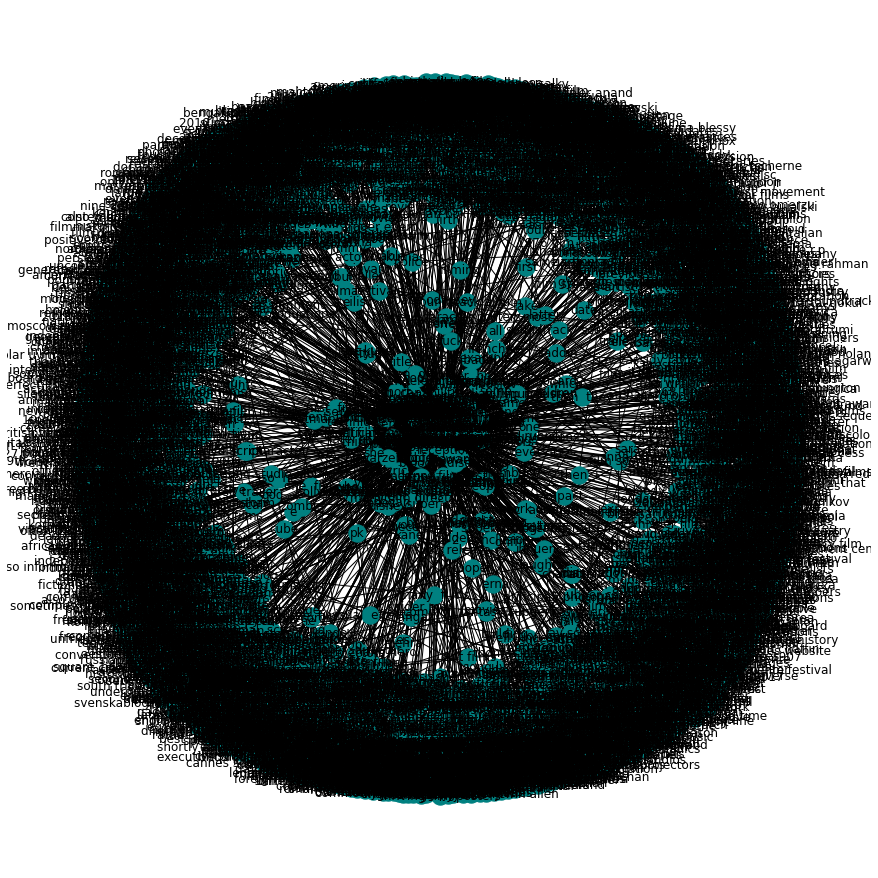

In [28]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [21]:
kg_df[20:30]

,source,target,edge
20,last which,penn,stand
21,jessica chastain,same character,considered for
22,mauro fiore,cinematographer,served as
23,filming,october,completed on
24,soundtrack,digitally june,released
25,album,digitally august,released
26,film,studios motion pictures,distributed by
27,it,$ 103.7,ended
28,,,chandler
29,it,executive producer yoshimitsu banno,dedicated to executive


Knowledge Graph for "edge" cloumn values(edge=relations)

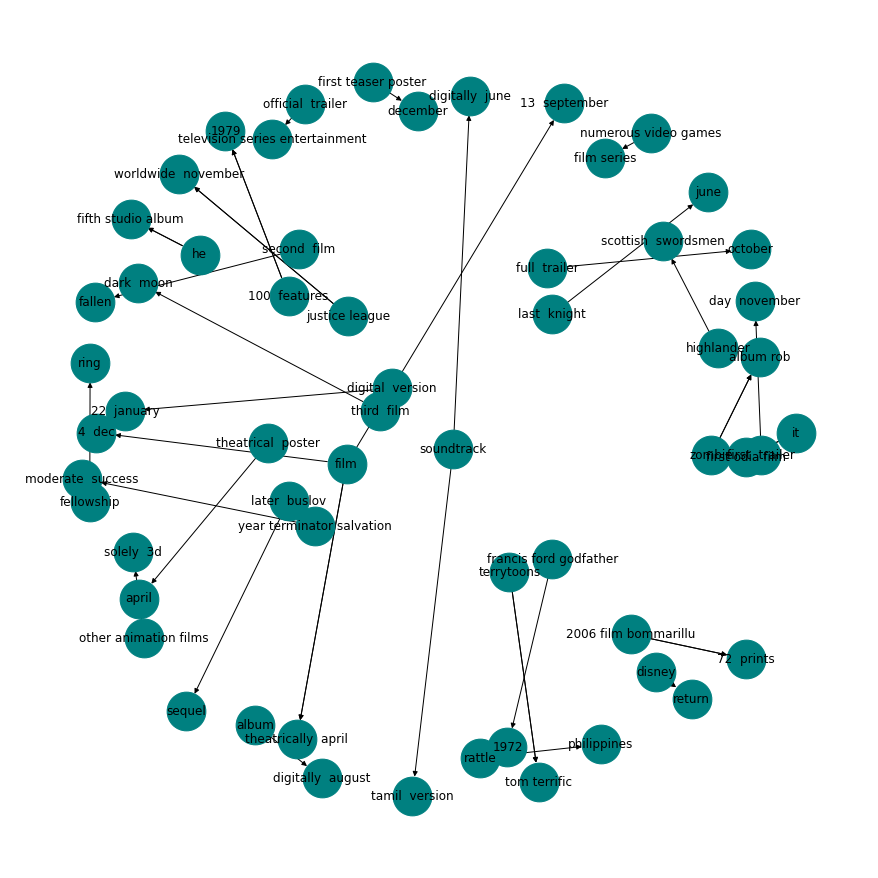

In [22]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='teal', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

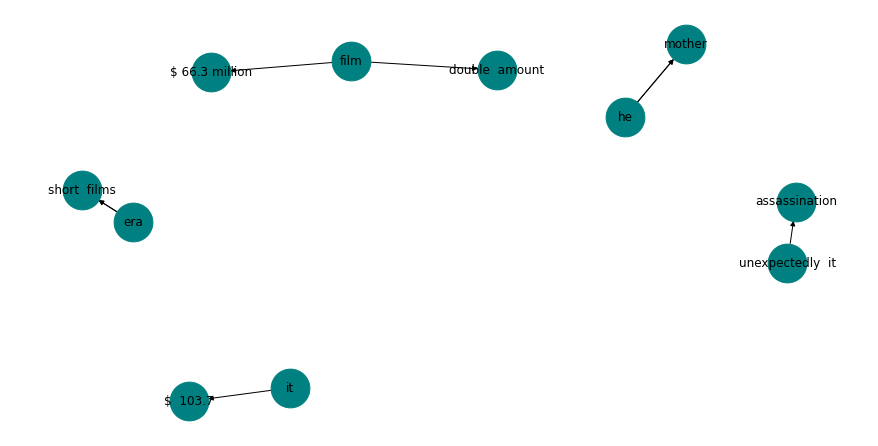

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="ended"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,6))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='teal', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

References

- https://medium.com/@edezhic/understanding-knowledge-graphs-5cb05593eb84
- https://medium.com/octavian-ai/deep-learning-with-knowledge-graphs-3df0b469a61a
- https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/
- https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/